## Installing Imports

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip install emoji --upgrade
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*
    !python -m spacy download en_core_web_lg
    !pip install pyldavis
    !pip install gensim
    !pip install chart_studio
    !pip install --upgrade autopep8

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=a6b56215f132269676a04f25ff077db997516b77a8075b3b7f3ef597b27708cb
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji
     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 604kB 9.0MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 3.1MB 12.5MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 296kB 33.9MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=7c5117d1c44f91c736556d69ae7f82b559d6a23b3d3c10df118d10bf958817e9
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for 

In [ ]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


## Imports

In [ ]:
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter

In [ ]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

In [ ]:
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
import warnings
warnings.filterwarnings('ignore')

## Loading Text

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [337]:
data = pd.read_csv('month1_metooindia_tweet.csv', error_bad_lines=False)
data_text = data[['tweet']]
# data_text['index'] = data_text.index

# documents = data_text

print(data_text.head())


                                               tweet
0  #MeToo #MeTooindia FIR lodged0569/16 on ACCUSE...
1  2/ Homegrown is running a list of men outed by...
2  #Meetoo #MeTooIndia #MeToo india #MeTooControv...
3  #RakhiSawant is giving all the people in #Indi...
4  shame on alok nath vikash behl n sajid khan n ...


In [338]:
def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

In [342]:
call_emoji_free = lambda x: give_emoji_free_text(x)
data_text['emoji_free_tweets'] = data_text['tweet'].apply(call_emoji_free)

#Create a new column with url free tweets
data_text['url_free_tweets'] = data_text['emoji_free_tweets'].apply(url_free_text)

In [343]:
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(data_text['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
data_text['tokens'] = tokens


In [344]:
data_text['tokens_back_to_text'] = [' '.join(map(str, l)) for l in data_text['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

data_text['lemmas'] = data_text['tokens_back_to_text'].apply(get_lemmas)

In [345]:
data_text['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in data_text['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
data_text['lemma_tokens'] = data_text['lemmas_back_to_text'].apply(tokenize)


In [ ]:
data_text.head()

,tweet,emoji_free_tweets,url_free_tweets,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,"Everytime I log on to twitter, I wonder who is...","Everytime I log on to twitter, I wonder who is...","Everytime I log on to twitter, I wonder who is...","[everytime, log, twitter,, wonder, new, shark,...","everytime log twitter, wonder new shark pulled...","[everytime, log, twitter, wonder, new, shark, ...",everytime log twitter wonder new shark pull se...,"[everytime, log, twitter, wonder, new, shark, ..."
1,"#MeToo in India: AIB loses lucrative deals, ma...","#MeToo in India: AIB loses lucrative deals, ma...","#MeToo in India: AIB loses lucrative deals, ma...","[#metoo, india:, aib, loses, lucrative, deals,...","#metoo india: aib loses lucrative deals, disso...","[metoo, india, aib, lose, lucrative, deal, dis...",metoo india aib lose lucrative deal dissolve soon,"[metoo, india, aib, lose, lucrative, deal, dis..."
2,Gursimran Khamba of the AIB group sent on leav...,Gursimran Khamba of the AIB group sent on leav...,Gursimran Khamba of the AIB group sent on leav...,"[gursimran, khamba, aib, group, sent, leave, f...",gursimran khamba aib group sent leave followin...,"[gursimran, khamba, aib, group, send, leave, f...",gursimran khamba aib group send leave follow a...,"[gursimran, khamba, aib, group, send, leave, f..."
3,The sad part of #MeToo movement is as soon as ...,The sad part of #MeToo movement is as soon as ...,The sad part of #MeToo movement is as soon as ...,"[sad, #metoo, movement, soon, storm, pass,, sa...","sad #metoo movement soon storm pass, sacked re...","[sad, metoo, movement, soon, storm, pass, sack...",sad metoo movement soon storm pass sack resign...,"[sad, metoo, movement, soon, storm, pass, sack..."
4,#MeToo ripples: AIB ends association with Tanm...,#MeToo ripples: AIB ends association with Tanm...,#MeToo ripples: AIB ends association with Tanm...,"[#metoo, ripples:, aib, ends, association, tan...",#metoo ripples: aib ends association tanmay bh...,"[metoo, ripple, aib, ends, association, tanmay...",metoo ripple aib ends association tanmay bhat ...,"[metoo, ripple, aib, ends, association, tanmay..."


In [ ]:
def model_lda(data_text):
    id2word = Dictionary(data_text['lemma_tokens'])
    id2word.filter_extremes(no_below=2, no_above=.99)
    corpus = [id2word.doc2bow(d) for d in data_text['lemma_tokens']]
    base_model = LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, workers=12, passes=20,iterations=70)
    words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]
    topics = [' '.join(t[0:10]) for t in words]
    return base_model,corpus,id2word,topics


In [346]:
base_model,corpus,id2word,topics = model_lda(data_text)
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
metoo metooindia victim sexual sajidkhan support harassment people timesup woman

------ Topic 1 ------
metoo metooindia man woman time support movement come timesup harassment

------ Topic 2 ------
metoo metooindia mjakbar akbar minister mj woman resign priyaramani bjp

------ Topic 3 ------
metoo metooindia movement india industry u people film female d

------ Topic 4 ------
metoo metooindia tweet harassment sexual woman story come chinmayi people

------ Topic 5 ------
metoo metooindia woman timesup come man u life story go

------ Topic 6 ------
metoo metooindia timesup woman india need speak campaign power come

------ Topic 7 ------
metoo metooindia woman man shame movement indian girl know mjakbar

------ Topic 8 ------
metoo metooindia sexual accuse allegation harassment movement aloknath bollywood metoocontroversy

------ Topic 9 ------
metooindia metoo woman home detail india note delhi south movement



In [ ]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=data_text['lemma_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -6.508764146461481

Coherence Score:  0.31669008899963524


In [348]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.033408 -0.033193       1        1  15.548075
4      0.022423 -0.026167       2        1  12.228328
1      0.053906 -0.002890       3        1  11.412899
6      0.048779  0.014455       4        1  11.245325
2     -0.205335 -0.071024       5        1  10.910648
7      0.001609  0.017875       6        1   8.924611
0     -0.001412 -0.046729       7        1   8.887148
5      0.034421 -0.023594       8        1   7.487675
3      0.077020 -0.011412       9        1   7.301990
9     -0.064819  0.182679      10        1   6.053302, topic_info=         Term         Freq        Total Category  logprob  loglift
281   mjakbar  1805.000000  1805.000000  Default  30.0000  30.0000
1056    akbar   666.000000   666.000000  Default  29.0000  29.0000
144     tweet   659.000000   659.000000  Default  28.0000  28.0000
23        man  1908.000000  1908.000000  Default  27.0000  27.0000
74      woman  3938.000000  3938.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
199      call    57.513686   501.759389  Topic10  -5.6715   0.6385
109    sexual    87.607958  1953.446427  Topic10  -5.2507  -0.2999
92    timesup    82.326334  1763.590736  Topic10  -5.3128  -0.2598
23        man    79.181292  1908.445229  Topic10  -5.3518  -0.3777
281   mjakbar    72.840330  1805.562269  Topic10  -5.4353  -0.4058

[800 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
627       2  0.955880  1027/2018
402       4  0.195831  23_rahulr
402       8  0.783325  23_rahulr
4008      2  0.920603   29simran
3663      5  0.952338         31
...     ...       ...        ...
1536      8  0.005092          ⁠
1536      9  0.010183          ⁠
1536     10  0.295313          ⁠
8366      5  0.942026         ⁠⁠
4673      6  0.880152     ₹3,000

[2673 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 2, 7, 3, 8, 1, 6, 4, 10])

In [ ]:
df = data_text[['lemma_tokens']] 
df['date'] = data['date']
df.drop(df[df['date'] == 'date'].index, inplace = True)
df['date'] = pd.to_datetime(df['date'])  
df.reset_index(drop=True,inplace=True)
df.head()

,lemma_tokens,date
0,"[issue, megan, kelly, pro, metoo, admit, work,...",2018-10-25 20:08:56
1,"[papajohns, employee, fight, workplace, free, ...",2018-10-25 21:49:34
2,"[metoo, option, support, complaint, allegation...",2018-10-25 23:12:43
3,"[support, survivor, sexual, harassment, sign, ...",2018-10-25 18:26:21
4,"[appear, simple, claim, metoo, fear, certain, ...",2018-10-25 21:11:29


In [ ]:
def keyword_trend(df,keyword):
    l = []
    for keys in df['lemma_tokens']:
        if keyword in keys:
            l.append(True)
        else:
            l.append(False)
    l1 = pd.Series(l)
    df1 = df[l1]
    df1.reset_index(drop=True,inplace=True)
    df1 = df1.set_index('date')
    df1['Date'] = df1.index.date
    plt.figure(figsize=(10,5))
    plt.title('Trend of '+ keyword)
    df1['Date'].value_counts(normalize=True).sort_index().plot(kind='bar')

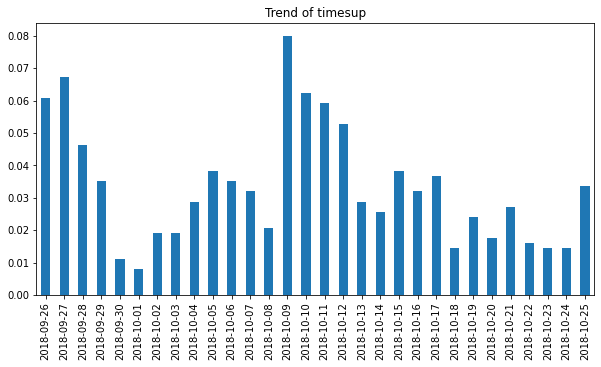

In [ ]:
keyword_trend(df,'timesup')

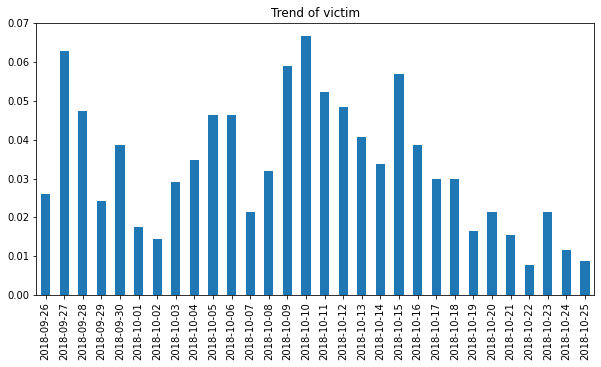

In [ ]:
keyword_trend(df,'victim')

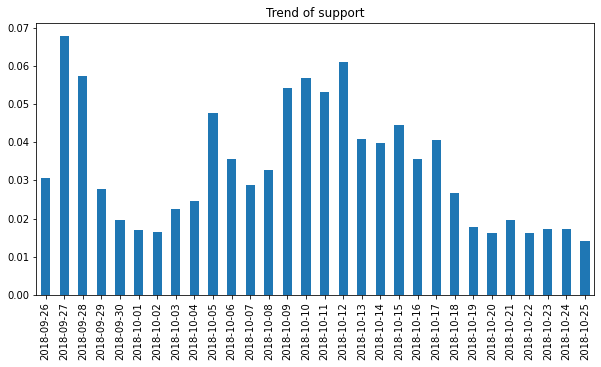

In [ ]:
keyword_trend(df,'support')

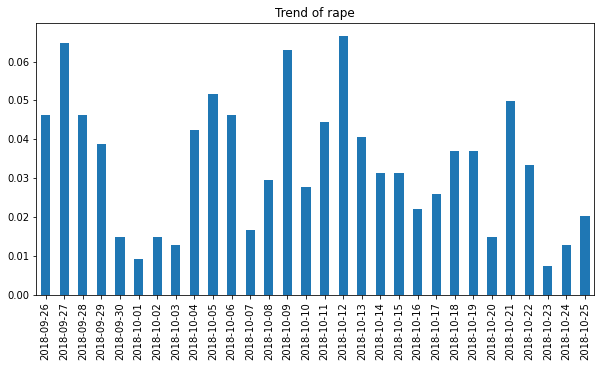

In [ ]:
keyword_trend(df,'rape')